In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from matplotlib import colors as colors
from matplotlib import animation
from matplotlib import colorbar
import pandas as pd
import math
from sklearn import preprocessing
!pip install --upgrade geopandas
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade descartes
!pip install --upgrade mapclassify
!pip install pycountry

import pycountry 
import geopandas

Requirement already up-to-date: geopandas in /usr/local/lib/python3.7/dist-packages (0.9.0)
Requirement already up-to-date: pyshp in /usr/local/lib/python3.7/dist-packages (2.1.3)
Requirement already up-to-date: shapely in /usr/local/lib/python3.7/dist-packages (1.7.1)
Requirement already up-to-date: descartes in /usr/local/lib/python3.7/dist-packages (1.1.0)
Requirement already up-to-date: mapclassify in /usr/local/lib/python3.7/dist-packages (2.4.2)


In [ ]:
data = pd.read_csv('time-series-19-covid-combined.csv')
data['month'] = pd.DatetimeIndex(data['Date']).month
df = pd.DataFrame(data, columns=data.columns)

In [ ]:
# normalizing feature values using minmax scalar from sklearn
scaler = preprocessing.MinMaxScaler()
fit = scaler.fit_transform(df[['Lat','Long', 'Confirmed', 'Recovered', 'Deaths']])
df[['Lat','Long', 'Confirmed', 'Recovered', 'Deaths']] = fit

In [ ]:
# SOM Parameters
lr=0.05
iterations= 1000
m = 10
n = 10
radius = max(m, n) / 2
time_constant = iterations / math.log(radius)

In [ ]:
# initialize net
rng = np.random.default_rng()
map = rng.random((m, n, 5))
# print(map)

In [ ]:
# helper functions
def distance(w, t):
    dist = 0
    for i in range(w.shape[0]):
      dist += abs(w[i] - t[i])**2
    return dist
 
def BMU(t, map:np.array):
  bmu_idx = [0, 0]
  min_dist = math.inf
 
  for i in range(map.shape[0]):
    for j in range(map.shape[1]):
      w = map[i, j, :]
      dist = distance(w, t)
      if dist < min_dist:
        min_dist = dist
        bmu_idx = [i, j]
 
  # bmu_idx = map[bmu_idx[0], bmu_idx[1], :]
  return bmu_idx
 
def decay_vals(i, radius, lr, time_constant, iterations):
  rad_upd = radius*math.exp(-i/time_constant)
  lr_upd = lr*math.exp(-i/iterations)
  return rad_upd, lr_upd
 
def influence(distance, radius):
  return math.exp(-distance / (2 * (radius**2)))

def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE

In [ ]:
def SOM(data):
  cmap = plt.get_cmap('plasma')
  norm = colors.Normalize(vmin=0, vmax=1)
  ims = []
  fig, ax = plt.subplots()

  ft_idx = [2, 3, 5, 6, 7]
  for k in range(iterations):
    t = [data.sample().to_numpy()[0][i] for i in ft_idx]
    bmu = BMU(t, map)
    radius_decay, lr_decay = decay_vals(k, radius, lr, time_constant, iterations)
    # print(lr, lr_decay)
    # print(radius_decay)
    for i in range(m):
      for j in range(n):
        w = map[i, j, :]
        dist = (bmu[0] - i)**2 + ((bmu[1] - j))**2 # dist of weight from bmu
        if dist <= radius_decay**2:
          inf = influence(dist, radius_decay)
          map[i, j, :] = w + (lr_decay * inf * (t - w))
    if k % 100 == 0:
      output = np.sum(map, axis=2)
      im = plt.imshow((output/np.max(output)), animated=True, cmap=cmap, norm=norm)      
      ims.append([im])

  fig, ax = plt.subplots(figsize=(6, 1))
  fig.subplots_adjust(bottom=0.5)
  cb1 = colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
  plt.show()

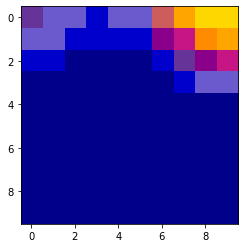

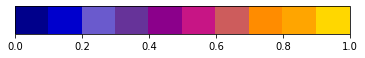

In [ ]:
SOM(data)

Month no. 1


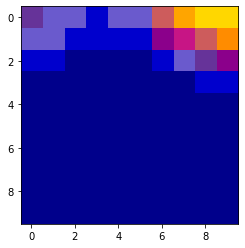

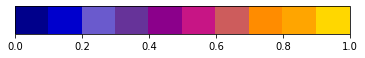

Month no. 2


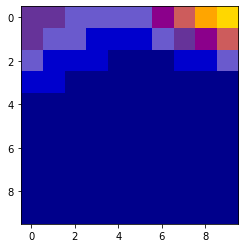

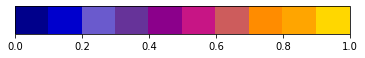

Month no. 3


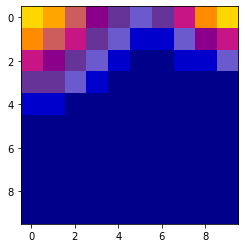

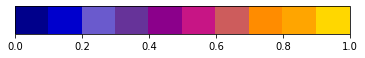

In [ ]:
for i in range(1, 4):
  monthly_data = data.loc[data['month'] == i]
  print('Month no.', i)
  if monthly_data.empty:
    continue
  else:
    SOM(monthly_data)
plt.show()

In [ ]:
def visualizeWorld(data, map):
    ''' reference: https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b '''
    bmu = []
    for idx, row in data.iterrows():
      t = row[['Lat','Long', 'Confirmed', 'Recovered', 'Deaths']]
      bmu_idx = BMU(t, map)
      bmu.append(np.sum(map[bmu_idx[0],bmu_idx[1],:]))
    data.loc[: , 'BMU'] = bmu

    # print(data)
    
    # cmap = plt.get_cmap('plasma')
    # norm = colors.Normalize(vmin=0, vmax=1)
    # world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    # # rename the columns so that we can merge with our data
    # world.columns=['pop_est', 'continent', 'name', 'Country Code', 'gdp_md_est', 'geometry']
    # merge=pd.merge(world, data,on='Country Code')
    # location=pd.read_csv('country_centroids_az8.csv')
    # location = location[['name', 'Longitude', 'Latitude']]
    # location['name'].replace({'United States':'United States of America'}, inplace=True)
    # merge=merge.merge(location,on='name')
    # merge.plot(column='BMU',
    #        figsize=(20, 10),
    #        legend=True,cmap=cmap, norm=norm)
    
    
    world = geopandas.read_file('time-series-19-covid-combined.csv')
    # rename the columns so that we can merge with our data
    world.columns=['State', 'Country', 'Lat',	'Long',	'Date',	'Confirmed',	'Recovered',	'Deaths', 'geometry']
    data['CODE']=alpha3code(data['Country/Region'])
    world['CODE']=data['CODE']
    location=pd.read_csv('centroids.csv')
    location = location[['name', 'Longitude', 'Latitude']]
    location['name'].replace({'United States':'United States of America'}, inplace=True)
    print(world.head())
    merge=pd.merge(world, data,on='CODE')
    merge=merge.merge(location,on='name')
    merge.plot(column='BMU',
           figsize=(20, 10),
           legend=True,cmap=cmap, norm=norm)
    # merge=pd.merge(world,data,on='Country').sort_values(by='Confirmed',ascending=False).reset_index()
    world.plot(column='Confirmed', scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap=cmap)
    plt.title('Confirmed Cases Around the World',fontsize=25)
    plt.show()

In [ ]:
# visualizeWorld(pd.read_csv('time-series-19-covid-combined.csv'), map)